In [1]:
%matplotlib inline

import altair as alt
import pandas as pd
import nivapy3 as nivapy
import matplotlib.pyplot as plt
import utils

plt.style.use('ggplot')

# Ion balances for 1000 Lakes survey

See e-mail from Atle received 18.02.2020 at 09.32 for details.

## 1. Read data

In [2]:
# Read data from main visualisation
df = pd.read_csv('../1000_lakes_lw_am.csv')
df = df.query('status in ("Entered", "Authorised", "Modified")')
df['par_unit'] = df['parameter'] + '-' + df['units']
df.head()

,sample_id,station_id,station_name,station_type,sample_date,parameter,status,loq,value_lw,units,value_am,par_unit
0,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Bly,Authorised,"0,01",0.68,UG_P_L,0.660,Bly-UG_P_L
1,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Aluminium,Authorised,1,390.00,UG_P_L,24.000,Aluminium-UG_P_L
2,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Arsen,Authorised,"0,02",0.33,UG_P_L,0.357,Arsen-UG_P_L
3,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Kobber,Authorised,"0,05",1.10,UG_P_L,1.000,Kobber-UG_P_L
4,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Krom,Authorised,"0,05",0.46,UG_P_L,0.400,Krom-UG_P_L


**Note:** The code below **fills missing data with zero** before performing the ion balance calculations. If this is not desirable, set `fillna=False` in the calls to `utils.ion_balance()`.

## 2. Perform ion balance

In [3]:
# Split into batches based on Ca concentrations in Labware
ca_levels = ['0.0 <= Ca_mgpl < 0.5',
             '0.5 <= Ca_mgpl < 1.0',
             '1.0 <= Ca_mgpl < 2.0',
             'Ca_mgpl >= 2']

# Loop over Ca "levels"
res_dict = {}
for ca_level in ca_levels:
    # Get Labware data
    lw_df = df[['station_id', 'station_name', 'sample_date', 'par_unit', 'value_lw']]
    lw_df = lw_df.groupby(['station_id', 'station_name', 'sample_date', 'par_unit']).mean()
    lw_df = lw_df.unstack('par_unit')
    lw_df.columns = lw_df.columns.get_level_values(1)
    lw_df.columns.name = None
    lw_df.reset_index(inplace=True)
    
    # Filter based on Ca value
    lw_df['Ca_mgpl'] = lw_df['Kalsium-MG_P_L']
    lw_df = lw_df.query(ca_level)
    del lw_df['Ca_mgpl']
    
    # Get AM data
    am_df = df[['station_id', 'station_name', 'sample_date', 'par_unit', 'value_am']]
    am_df = am_df.groupby(['station_id', 'station_name', 'sample_date', 'par_unit']).mean()
    am_df = am_df.unstack('par_unit')
    am_df.columns = am_df.columns.get_level_values(1)
    am_df.columns.name = None
    am_df.reset_index(inplace=True)
    
    # Ion balance
    lw_df = utils.ion_balance(lw_df, fillna=True)
    am_df = utils.ion_balance(am_df, fillna=True)
    
    # Merge    
    res_df = pd.merge(lw_df,
                      am_df,
                      on=['station_id', 'station_name', 'sample_date'],
                      how='left',
                      suffixes=['_lw', '_am'],
                     )

    # Filter columns
    res_df = res_df[['station_id', 'station_name', 'sample_date', 
                    'ion_diff_pct_lw', 'ion_diff_pct_am',
                    'kond_diff_pct_lw', 'kond_diff_pct_am',
                    'kond_minus_H&SO4_lw', 'kond_minus_H&SO4_am']]
    res_df.dropna(inplace=True)
    
    # Store output
    res_dict[ca_level] = res_df

## 3. Charts

### 3.1. Ion difference in percent

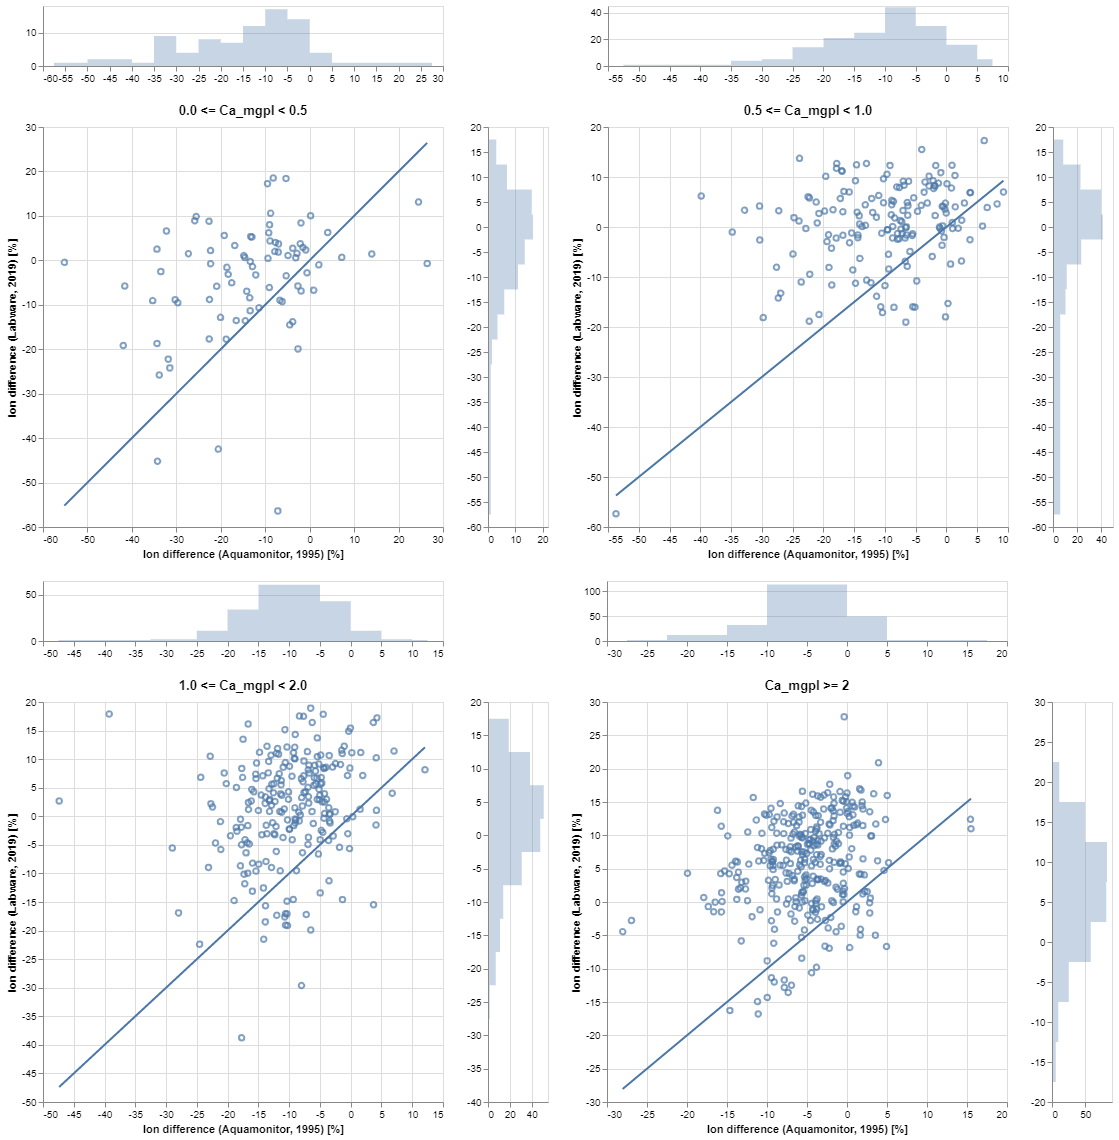

In [4]:
chart_dict = {}
for idx, ca_level in enumerate(ca_levels):
    data = res_dict[ca_level]

    base = alt.Chart(data, height=400, width=400)

    x_domain = alt.selection_interval(bind='scales', encodings=['x'])
    y_domain = alt.selection_interval(bind='scales', encodings=['y'])

    area_args = {'opacity': .3, 'interpolate': 'step'}

    points = base.mark_point().encode(
            x=alt.X('ion_diff_pct_am:Q', title='Ion difference (Aquamonitor, 1995) [%]'),
            y=alt.Y('ion_diff_pct_lw:Q', title='Ion difference (Labware, 2019) [%]'),
            tooltip=['station_id:N', 'station_name:N', 'sample_date:T', 'ion_diff_pct_lw:Q', 'ion_diff_pct_am:Q'],
        ).properties(
            title=ca_level
        ).add_selection(
            x_domain
        ).add_selection(
            y_domain
        )

    # 1:1 line
    line = base.mark_line().encode(
            x=alt.X('ion_diff_pct_am:Q', title=''),
            y=alt.Y('ion_diff_pct_am:Q', title=''),
        )

    top_hist = base.mark_area(**area_args).encode(
            alt.X('ion_diff_pct_am:Q',
                  bin=alt.Bin(maxbins=20),
                  stack=None,
                  title=''
                 ),
            alt.Y('count()', stack=None, title=''),
        ).properties(height=60).add_selection(
            x_domain
        )

    right_hist = base.mark_area(**area_args).encode(
            alt.Y('ion_diff_pct_lw:Q',
                  bin=alt.Bin(maxbins=20),
                  stack=None,
                  title='',
                 ),
            alt.X('count()', stack=None, title=''),
        ).properties(width=60).add_selection(
            y_domain
        )

    chart = top_hist & ((points + line) | right_hist)
    chart_dict[idx] = chart
    
chart = ((chart_dict[0] | chart_dict[1]) &
         (chart_dict[2] | chart_dict[3]))
chart.save('../pages/ion_difference_pct.html')
chart

### 3.2. Conductivity difference in percent

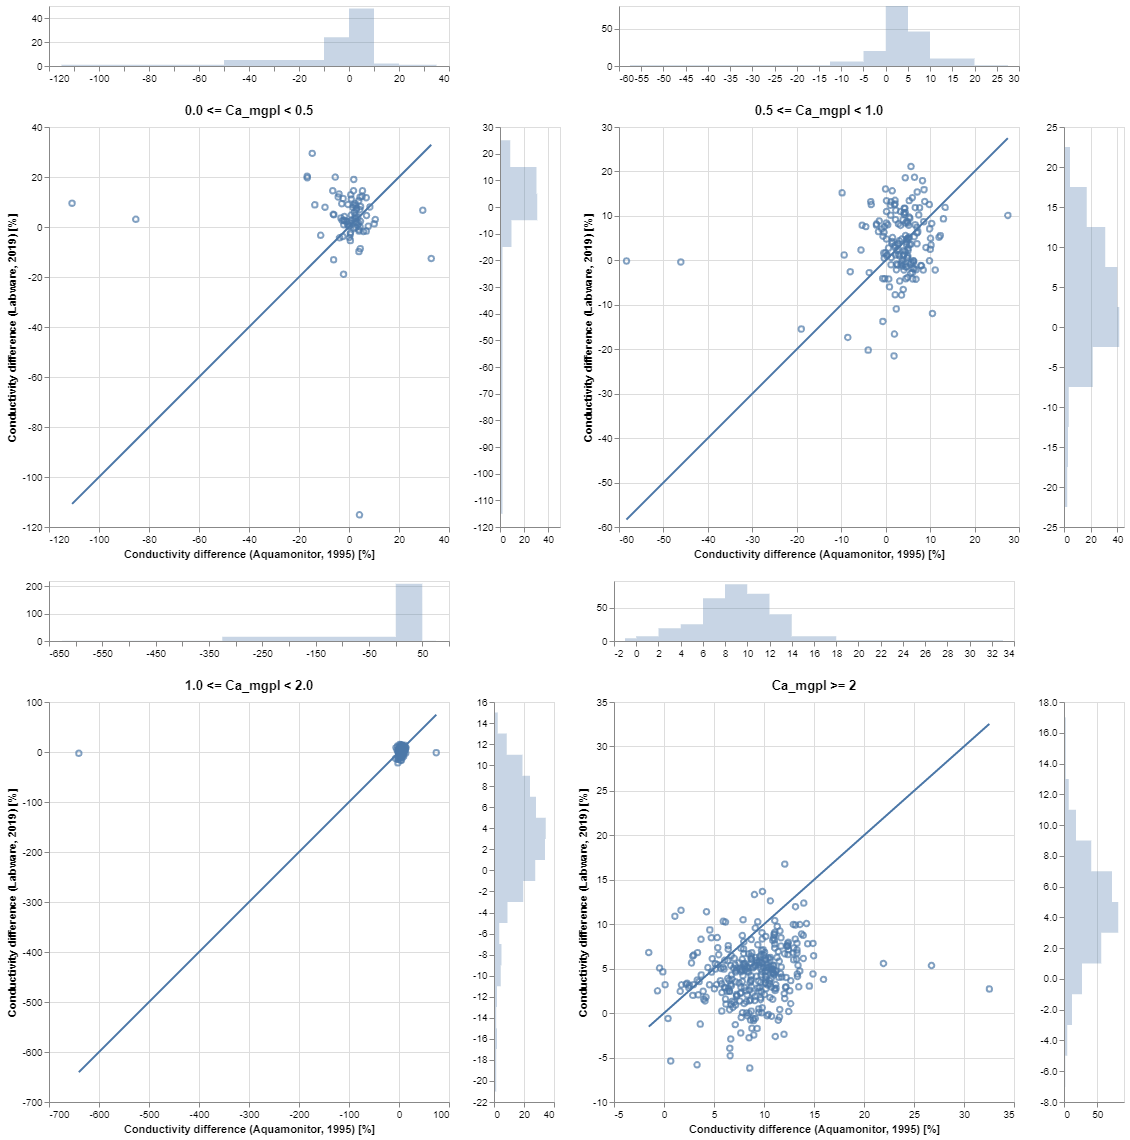

In [5]:
chart_dict = {}
for idx, ca_level in enumerate(ca_levels):
    data = res_dict[ca_level]

    base = alt.Chart(data, height=400, width=400)

    x_domain = alt.selection_interval(bind='scales', encodings=['x'])
    y_domain = alt.selection_interval(bind='scales', encodings=['y'])

    area_args = {'opacity': .3, 'interpolate': 'step'}

    points = base.mark_point().encode(
            x=alt.X('kond_diff_pct_am:Q', title='Conductivity difference (Aquamonitor, 1995) [%]'),
            y=alt.Y('kond_diff_pct_lw:Q', title='Conductivity difference (Labware, 2019) [%]'),
            tooltip=['station_id:N', 'station_name:N', 'sample_date:T', 'kond_diff_pct_lw:Q', 'kond_diff_pct_am:Q'],
        ).properties(
            title=ca_level
        ).add_selection(
            x_domain
        ).add_selection(
            y_domain
        )

    # 1:1 line
    line = base.mark_line().encode(
            x=alt.X('kond_diff_pct_am:Q', title=''),
            y=alt.Y('kond_diff_pct_am:Q', title=''),
        )

    top_hist = base.mark_area(**area_args).encode(
            alt.X('kond_diff_pct_am:Q',
                  bin=alt.Bin(maxbins=20),
                  stack=None,
                  title=''
                 ),
            alt.Y('count()', stack=None, title=''),
        ).properties(height=60).add_selection(
            x_domain
        )

    right_hist = base.mark_area(**area_args).encode(
            alt.Y('kond_diff_pct_lw:Q',
                  bin=alt.Bin(maxbins=20),
                  stack=None,
                  title='',
                 ),
            alt.X('count()', stack=None, title=''),
        ).properties(width=60).add_selection(
            y_domain
        )

    chart = top_hist & ((points + line) | right_hist)
    chart_dict[idx] = chart
    
chart = ((chart_dict[0] | chart_dict[1]) &
         (chart_dict[2] | chart_dict[3]))
chart.save('../pages/cond_difference_pct.html')
chart

### 3.3. Corrected conductivity

Calculated as

$$K_{corr} = K_{raw} - 0.035H^+ - 0.008SO_4$$

where $K_{corr}$ is in mS/m and $H^+$ & $SO_4$ are in ueq/l.

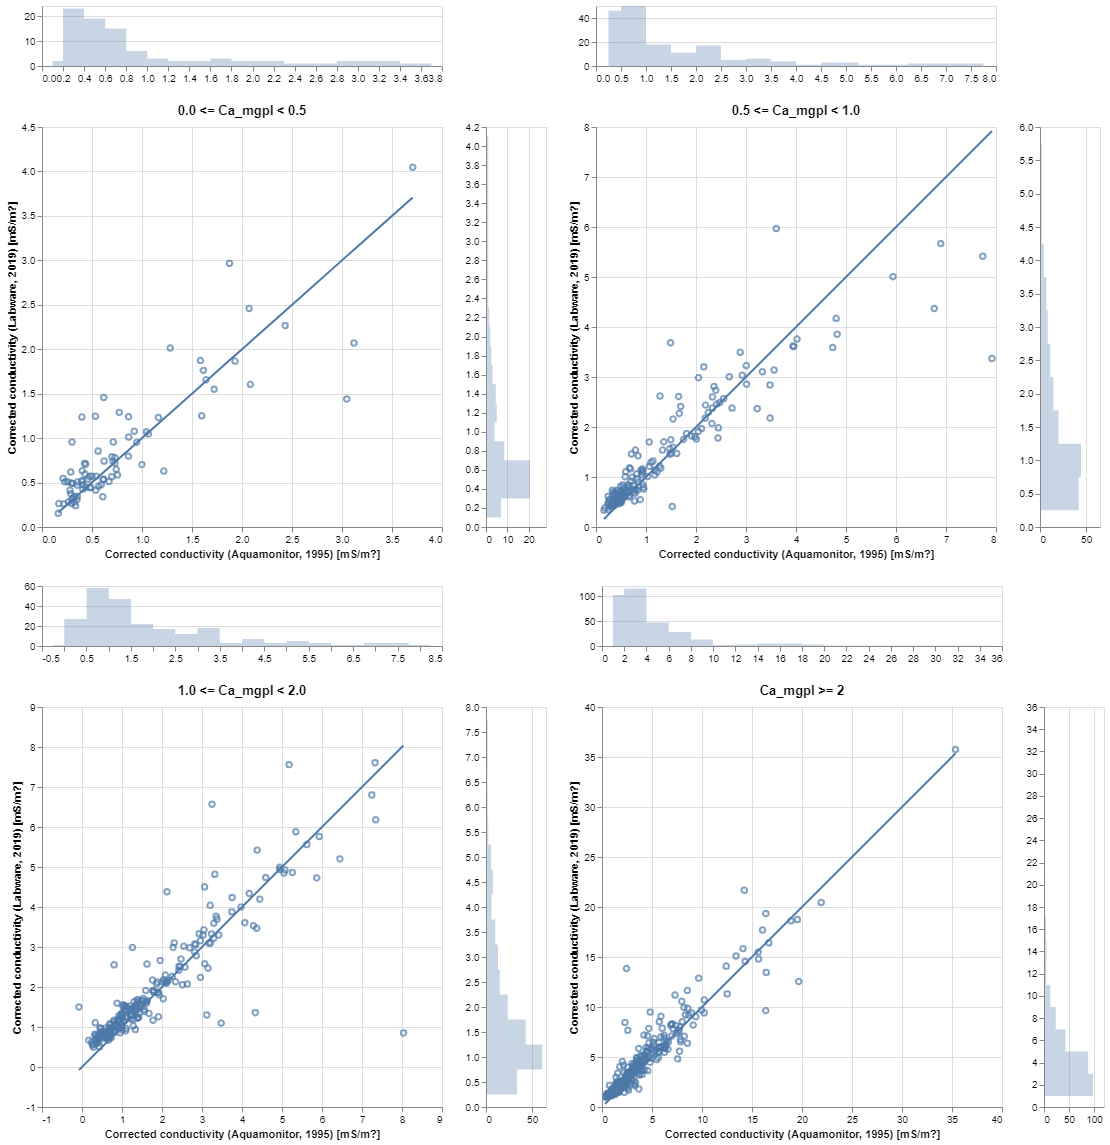

In [6]:
chart_dict = {}
for idx, ca_level in enumerate(ca_levels):
    data = res_dict[ca_level]

    base = alt.Chart(data, height=400, width=400)

    x_domain = alt.selection_interval(bind='scales', encodings=['x'])
    y_domain = alt.selection_interval(bind='scales', encodings=['y'])

    area_args = {'opacity': .3, 'interpolate': 'step'}

    points = base.mark_point().encode(
            x=alt.X('kond_minus_H&SO4_am:Q', title='Corrected conductivity (Aquamonitor, 1995) [mS/m?]'),
            y=alt.Y('kond_minus_H&SO4_lw:Q', title='Corrected conductivity (Labware, 2019) [mS/m?]'),
            tooltip=['station_id:N', 'station_name:N', 'sample_date:T', 'kond_minus_H&SO4_lw:Q', 'kond_minus_H&SO4_am:Q'],
        ).properties(
            title=ca_level
        ).add_selection(
            x_domain
        ).add_selection(
            y_domain
        )

    # 1:1 line
    line = base.mark_line().encode(
            x=alt.X('kond_minus_H&SO4_am:Q', title=''),
            y=alt.Y('kond_minus_H&SO4_am:Q', title=''),
        )

    top_hist = base.mark_area(**area_args).encode(
            alt.X('kond_minus_H&SO4_am:Q',
                  bin=alt.Bin(maxbins=20),
                  stack=None,
                  title=''
                 ),
            alt.Y('count()', stack=None, title=''),
        ).properties(height=60).add_selection(
            x_domain
        )

    right_hist = base.mark_area(**area_args).encode(
            alt.Y('kond_minus_H&SO4_lw:Q',
                  bin=alt.Bin(maxbins=20),
                  stack=None,
                  title='',
                 ),
            alt.X('count()', stack=None, title=''),
        ).properties(width=60).add_selection(
            y_domain
        )

    chart = top_hist & ((points + line) | right_hist)
    chart_dict[idx] = chart
    
chart = ((chart_dict[0] | chart_dict[1]) &
         (chart_dict[2] | chart_dict[3]))
chart.save('../pages/corrected_cond.html')
chart